# Likelihood
### open source data quality monitor

Colin Jemmott
2020

Have you ever found out an ETL job failed because a customer called?  You ever retrain a machine learning model in production just to find out the data changed out from under you?  Have a dashboard break because new data violated your assumptions?

### Approach

Everything is probability (or, rather [surprise](https://en.wikipedia.org/wiki/Entropy_(information_theory)#Introduction)!).  Works on a two dataframes for now - you have to get the data.

Batch job, you pass in training and test.

Taxonomy of problems for initial launch:
- New values in categorical - bootstrapping
- Missing values - bootstrapping (Nan is just another category)
- Outliers in counts (missing or spike) - prophet

To Do:

- Outliers in counts of groups - bootstrapping
- Outliers in values - kernel density?

Later:
- Outliers in correlation between categories - assocation rules / Bayesian network / just conditional probability
- Delayed data (I think we need a writtenAt timestamp)
- Multi-table: check joins
- PCA?  Other anomaly detection?
- Multitenant

### Tips

Some of the analysis assumes that the data is stationary (ergodic).  If that is a bad assumption it might make sense to trim history.  maxTrainingSizeMultiple controls that.

### To Do

- Change out data for something public (SDPD?)
- Write params to JSON
- preprocessor on bootsrtapping for columns with tons of entries.  Also numerical columns?
- Throw a warning or error if the testing sample is too small?

In [3]:
import pandas as pd
import math as mt
import dateutil
from datetime import datetime, timedelta
import requests as rd
import numpy as np
import scipy.stats
from sklearn import neighbors

# Get data

Not part of the actual product, but here for ease of testing.

In [91]:
import os
import pandas as pd
from datetime import datetime, timedelta


N_days = 90
batchHours = 7*24 # this grabs the most recent chunk and looks for differences with the remainder


# parameters (will put into JSON config file later)
params = {"fName": "pd_calls_for_service_2020_datasd.csv", # local CSV file only right now
          "ts": "date_time", # Timestamp for when the event happened in the world
          "bootstrapResamples":1000, # should probably be 10k for better accuracy, but much worse speed
          "maxTrainingSizeMultiple":10, # if there is more than X times more training data, trim to most recent
          "maxCategories":100, # maximum number of categories in a column - if higher we skip
          "minCategoryCount":10, # don't report boostrap surprise if a category has lower count
         }

## Load data, split into training and test

In [92]:
df = pd.read_csv("pd_calls_for_service_2020_datasd.csv")
if(df.shape[0] <= 1000):
    print("Warning: small data set might produce inaccurate results")
df['ts'] = df[params['ts']]
print(df)
#.apply(dateutil.parser.parse, ignoretz=True) # could speed this up for ISO8601 - currently slow.
df['ts'] =  pd.to_datetime(df['ts'], format='%Y%m%d %H:%M:%S')
maxTs = max(df['ts'])
#df = df.assign(date_time = df.get("date_time").apply(datetime.strptime, args = ("%d/%m/%Y %H:%M:%S")))
batchTs = maxTs - timedelta(hours = batchHours)
testDf = df[df['ts'] > batchTs]
trainDf = df[df['ts'] < batchTs]

FileNotFoundError: [Errno 2] File b'pd_calls_for_service_2020_datasd.csv' does not exist: b'pd_calls_for_service_2020_datasd.csv'

In [ ]:
trainDf.keys()

In [ ]:
max(trainDf['ts'])

In [ ]:
# Helpers and Math
def pValue(data, threshold):
    p_larger = sum(np.array(data) >= threshold) / len(data)
    p_smaller = sum(np.array(data) <= threshold) / len(data)
    p = min(p_larger, p_smaller)

    # only use gaussian p-value when there is variation, but bootsrap p = 0
    stdev = np.std(data)
    if stdev == 0 or p != 0:
        p_gauss = p
    else:
        p_gauss = scipy.stats.norm(np.mean(result['bootstrap_counts']), stdev).cdf(result['count'])
        p_gauss = min(p_gauss,1-p_gauss)
    return p_gauss

def trimTraining(trainDf, params):

    # trim to most recent
    trainDf = trainDf.sort_values(params['ts'], ascending =False)
    trainDfTrimmed = trainDf[:params['maxTrainingSizeMultiple']*len(testDf)]
    
    return trainDfTrimmed

In [90]:
# get all of the string columns
columnNames = []
for columnName in testDf.keys():
    if (type (testDf[columnName].iloc[0])) == str:
        columnNames.append(columnName)
print(columnNames)
bootstrapDf = trimTraining(trainDf, params)
        
# set up dict, add counts
results = {}
for columnName in columnNames:
    # if it isn't a string column, reject it
    if type(testDf[columnName].iloc[0]) != str:
        continue
    categories = (bootstrapDf[columnName].append(testDf[columnName])).unique()
    if len(categories) > params['maxCategories']:
        continue
    
    results[columnName] = {}
    testCounts = testDf[columnName].value_counts(dropna = False)
    for i in np.arange(1,len(categories) -1):
        if(pd.isna(categories[i])):
            categories = np.delete(categories, i)  
    for category in categories:
        results[columnName][category] = {'bootstrap_counts':[],
                                        'count':testCounts.get(category,0)}
# resample, add boostrap counts
for ii in range(params['bootstrapResamples']):
    # Draw random sample from training
    sampleDf = bootstrapDf.sample(len(testDf), replace=True)
    for columnName in results.keys():
        # count by category
        trainCounts = sampleDf[columnName].value_counts(dropna = False)
        # put results in dict
        for category in results[columnName].keys():
            boostrapCount = trainCounts.get(category,0)
            results[columnName][category]['bootstrap_counts'].append(boostrapCount)
              
# convert to records, add p-values
bootstrap_results = []
for columnName in results.keys():
    for category in results[columnName].keys():
        result = results[columnName][category]
        
        estimatedCount = int(np.round(np.mean(result['bootstrap_counts'])))
        # don't report entries with very low predicted and actual counts
        if estimatedCount < params['minCategoryCount'] and result['count'] < params['minCategoryCount']:
            continue
        
        p = pValue(result['bootstrap_counts'],result['count'])
        categoryName = category
        if not category:
            categoryName = "NULL"
        
        bootstrap_results.append({"column":columnName,
                           "category":categoryName,
                           "count":result['count'],
                           "p": p,
                           "estimated_count":estimatedCount,
                           })
if(np.count_nonzero(p)>0):
    resultsDf = pd.DataFrame.from_records(bootstrap_results).sort_values('p')
    resultsDf['surprise'] = -np.log2(resultsDf['p'])

NameError: name 'testDf' is not defined

In [89]:
resultsDf.head(70)

NameError: name 'resultsDf' is not defined

# Timeseries forecast (prophet)

Installing prophet is a major pain, especially on Windows.  Details: https://facebook.github.io/prophet/docs/installation.html

Following the lead from Seismic interns: https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473

Decided to go hourly, but could change to day with a few tweaks.

In [ ]:
from fbprophet import Prophet

In [ ]:
def truncateTs(ts):
    return ts.replace(minute=0, second=0,  microsecond=0)

In [ ]:
truncatedData = trainDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetDf = pd.DataFrame({'ds':groupedCounts.index,'y':np.log10(groupedCounts.values)})
prophetDf

In [ ]:
# find number of hours to preduct: ceil of hours in testDf
timeDelta = max(testDf['ts']) -min(testDf['ts'])
hours = int(timeDelta.days*24 + timeDelta.seconds/(60*60))+1
 
# Train model
m = Prophet(#daily_seasonality = True, 
            #yearly_seasonality = False, 
            #weekly_seasonality = True, 
            #growth='linear',
            interval_width=0.68 # one sigma
           )
m.add_country_holidays(country_name='US')

m.fit(prophetDf)

future = m.make_future_dataframe(periods = hours, freq = 'H')
fcst = m.predict(future)

In [ ]:
# group the test data
truncatedData = testDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetTestDf = pd.DataFrame({'ds':groupedCounts.index,
                              'y':np.log10(groupedCounts.values),
                              'y_linear':groupedCounts.values})

# find p-value
prophet_results = []

for ii in range(len(prophetTestDf)):
    ts = prophetTestDf['ds'][ii]
    fcstExample = fcst[fcst['ds'] == ts]
    mean = fcstExample['yhat'].iloc[0]
    stdev = (fcstExample['yhat_upper'].iloc[0] - fcstExample['yhat_lower'].iloc[0])/2
    p = scipy.stats.norm(mean, stdev).cdf(prophetTestDf['y'][ii])
    p = min(p,1-p)

    prophet_results.append({"column":"Forecast",
                       "category":str(ts),
                       "count":prophetTestDf['y_linear'][ii],
                       "p": p,
                       "estimated_count":int(np.round(np.power(10,mean))),
                       })
    
prophetResultsDf = pd.DataFrame.from_records(prophet_results).sort_values('p')
prophetResultsDf['surprise'] = -np.log2(prophetResultsDf['p'])
prophetResultsDf

In [ ]:
# plotting for debug only
fig = m.plot(fcst)
fig = m.plot_components(fcst)

# Kernel Density Implementation Below

In [46]:
#Reading data in from the web, this is the data that I would like to use to track over the
#long term and find anomalies
#https://www.nbastuffer.com/2019-2020-nba-team-stats/
nam = input()
frame = pd.read_html(nam)
frame

https://www.nbastuffer.com/2019-2020-nba-team-stats/


[    RANK           TEAM  CONF   DIVISION  GP  \
 0    NaN        Atlanta  East  Southeast  67   
 1    NaN         Boston  East   Atlantic  64   
 2    NaN       Brooklyn  East   Atlantic  64   
 3    NaN      Charlotte  East  Southeast  65   
 4    NaN        Chicago  East    Central  65   
 5    NaN      Cleveland  East    Central  65   
 6    NaN         Dallas  West  Southwest  67   
 7    NaN         Denver  West  Northwest  65   
 8    NaN        Detroit  East    Central  66   
 9    NaN   Golden State  West    Pacific  65   
 10   NaN        Houston  West  Southwest  64   
 11   NaN        Indiana  East    Central  65   
 12   NaN    LA Clippers  West    Pacific  64   
 13   NaN      LA Lakers  West    Pacific  63   
 14   NaN        Memphis  West  Southwest  65   
 15   NaN          Miami  East  Southeast  65   
 16   NaN      Milwaukee  East    Central  65   
 17   NaN      Minnesota  West  Northwest  64   
 18   NaN    New Orleans  West  Southwest  64   
 19   NaN       New 

In [47]:
#Obtaining the first of the tables on the site
first_table = frame[1]
first_table

,RANK,TEAM,CONF,DIVISION,GP,PTS/GMPoints Per GameAverage points per game,aPTS/GMPoints Allowed Per GameAverage points allowed per game,PTS DIFFPoints Differential{(Total Points Scored) - (Total Points Allowed)}/ (Games Played),PACEPaceEstimate of Possessions Per 48 Minutes,OEFFOffensive EfficiencyPoints scored per 100 possessions.,...,SARSchedule Adjusted RatingAn evaluation of teams based on efficiency differential and strength of schedule,"CONSConsistency RatingConsistency based on game-by-game efficiency differential variation. The higher the team has a consistency rating, the more unpredictable it is.",A4FAdjusted Four FactorsCalculated by applying weights to the differentials of offensive and defensive four factors. A4F explains the specified proportion of variability in wins.,"WWinsThe most important goal in sports, unless your team is not tanking",LLossesTotal count of games lost,WIN%,eWIN%Correlated Gaussian Expected Winning PercentageIndicates the ideal winning percentage based on offensive and defensive performance.,pWIN%Projected Winning PercentageEach point differential translates to 2.7 wins over the course of the season.,ACHAchievement Level In Terms of Wins. The metric is based on differential between actual and expected winning percentage. Positive figures indicate overachievement while negative figures indicate the team should have won more games.,STRKLast 5 Games StreakWinning or losing streak for the last 5 games.
0,NaN,Atlanta,East,Southeast,5,115.0,127.4,-12.4,100.0,108.2,...,-15.89,16.2,-0.047,1,4,0.2,0.230,0.092,-0.030,L 1
1,NaN,Boston,East,Atlantic,5,108.8,110.0,-1.2,97.7,109.1,...,-1.50,5.9,-0.026,2,3,0.4,0.433,0.460,-0.033,W 1
2,NaN,Brooklyn,East,Atlantic,5,112.2,113.4,-1.2,100.3,108.9,...,-0.61,22.7,-0.006,4,1,0.8,0.465,0.460,0.335,W 3
3,NaN,Charlotte,East,Southeast,5,114.0,111.6,2.4,90.1,121.3,...,3.67,7.7,-0.004,2,3,0.4,0.647,0.579,-0.247,W 1
4,NaN,Chicago,East,Central,5,106.8,108.6,-1.8,99.6,107.3,...,-3.00,5.3,-0.042,2,3,0.4,0.366,0.441,0.034,W 1
5,NaN,Cleveland,East,Central,5,111.6,115.4,-3.8,96.5,113.0,...,-4.01,6.8,-0.015,2,3,0.4,0.273,0.375,0.127,L 1
6,NaN,Dallas,West,Southwest,5,115.8,109.4,6.4,100.5,112.9,...,5.38,14.3,-0.005,3,2,0.6,0.673,0.711,-0.073,W 1
7,NaN,Denver,West,Northwest,5,104.4,108.0,-3.6,96.4,108.6,...,-5.45,12.9,-0.017,2,3,0.4,0.381,0.381,0.019,L 1
8,NaN,Detroit,East,Central,5,100.4,110.2,-9.8,94.3,106.5,...,-9.17,5.5,-0.033,0,5,0.0,0.028,0.177,-0.028,L 5
9,NaN,Golden State,West,Pacific,5,112.8,118.0,-5.2,97.8,115.8,...,-4.65,16.2,-0.006,2,3,0.4,0.379,0.329,0.021,L 1


### Stat Computations for Formulas Found Below

In [48]:
def zMetrics(nums):
    # Currently using median because less likely to be influenced by outliers for calculation of
    # Standard Score. Subject to change.
    z_values = np.array([])
    u = nums.median()
    dev = nums.std()
    
    #Calculating z-scores
    for r in np.arange(len(nums)):
        z = abs((u - nums[r])/dev)
        z_values = np.append(z_values, z)
    return z_values

Enter the column name you'd like to get a kernel density estimation for:
PTS/GMPoints Per GameAverage points per game
Please enter the name of the column you'd like to serve as your index:
TEAM
0.03770210712649596


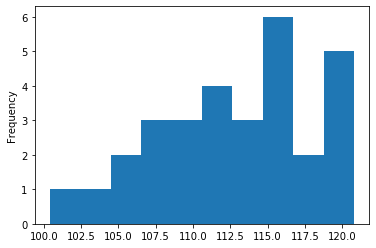

In [49]:
#Stuff beyond here focuses on kernel density, it is a work in progress
print("Enter the column name you'd like to get a kernel density estimation for:")

#Prompting user for input and calculating basic statistics, bandwidth temporarily set to .05
#For testing purposes
inp = input()
stat = first_table.get(inp)

#Index for purpose of making table nicer
print("Please enter the name of the column you'd like to serve as your index:")
indx = first_table.get(input())

#Plotting Data initially
stat.plot(kind  = "hist")
avg = stat.mean()
density = np.array([])
n = first_table.shape[0]
dev = np.std(stat)

#Rule of thumb estimator found on wikepedia for now:1.06 *sigma * n^-1/5
bandwidth = 1.06*dev*(n**-1/5)
print(bandwidth)

kernelEstimations = pd.DataFrame()


The Kernel Estimation for a Gaussian, Cosine, Triangular, and Parabolic Kernel are found below, metric used for surprise computation will be based on their average. Idea is: if between them we can found a standard density, we can find values that are more likely to be outliers. Other idea: find outliers for every one and check for commonalities.

### Scikit learn citation because their software is utilized
@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

In [50]:
# Using cosine kernel function to get estimate for log density
def cosKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'cosine').fit(stat)
    density = l.score_samples(stat)
    return density

In [51]:
# Using gaussian kernel function to get estimate for log density
def gaussKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'gaussian').fit(stat)
    density = l.score_samples(stat)
    return density

In [52]:
# Using linear kernel function to get estimate for log density
def triDense(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'linear').fit(stat)
    triDensity = l.score_samples(stat)
    return triDensity

In [53]:
# converted to Proportion for u < 1 supported functions
def toProp(number):
    return number/max(number)

In [54]:
# Using epanechnikov kernel function to get estimate for log density
def parabolicKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'epanechnikov').fit(stat)
    epDensity = l.score_samples(stat)
    return epDensity

## Kernel Values Data

In [55]:
# Assigning initial kernal estimations
def kernelEstimator(indx, stat):
    kernelEstimate = pd.DataFrame()
    print("Kernel Estimations as raw values found below:")
    kernelEstimate = kernelEstimate.assign(Data_Index = indx, Data_Point = stat,Gaussian = gaussKernel(stat),
                                               Epanechnikov = parabolicKernel(stat), Linear = triDense(stat),
                                               Cosine = cosKernel(stat))
    # temporary sort for some visualization of surprise
    kernelEstimate = kernelEstimate.sort_values(by = "Gaussian", ascending = False)
    return kernelEstimate
kernelEstimation = kernelEstimator(indx, stat)
kernelEstimation

Kernel Estimations as raw values found below:


,Data_Index,Data_Point,Gaussian,Epanechnikov,Linear,Cosine
27,Toronto,116.2,-2.577962,-2.333044,-2.302585,-2.324728
6,Dallas,115.8,-2.591776,-2.617296,-2.612740,-2.636240
26,San Antonio,116.6,-2.615355,-2.292635,-2.177422,-2.274873
25,Sacramento,116.6,-2.615355,-2.292635,-2.177422,-2.274873
0,Atlanta,115.0,-2.689539,-2.847312,-2.708050,-2.827365
23,Phoenix,117.0,-2.714933,-2.577022,-2.525729,-2.568766
14,Memphis,114.8,-2.716265,-2.847312,-2.708050,-2.827365
22,Philadelphia,120.0,-2.759223,-2.273026,-2.177422,-2.251443
12,LA Clippers,119.8,-2.767984,-2.364460,-2.238047,-2.331425
18,New Orleans,120.2,-2.778501,-2.282782,-2.238047,-2.272687


In [56]:
# Calculating their average
def surprise_estimator(kernelEstimation):
    avg = (kernelEstimation.get("Linear")+kernelEstimation.get("Epanechnikov")+kernelEstimation.get("Cosine")+kernelEstimation.get("Gaussian"))/4
    # Surprise Metric
    kernelEstimation  = kernelEstimation.assign(surprise = abs(avg))
    kernelEstimation = kernelEstimation.sort_values(by = "surprise", ascending = False)
    return kernelEstimation
kernelEstimation = surprise_estimator(kernelEstimation)
kernelEstimation

,Data_Index,Data_Point,Gaussian,Epanechnikov,Linear,Cosine,surprise
8,Detroit,100.4,-4.319627,-3.688879,-3.401197,-3.642762,3.763117
17,Minnesota,118.0,-3.101794,-3.688879,-3.401197,-3.642762,3.458658
4,Chicago,106.8,-3.276090,-3.194183,-3.064725,-3.180422,3.178855
19,New York,110.8,-2.904050,-3.146555,-3.064725,-3.161550,3.069220
9,Golden State,112.8,-2.833880,-3.194183,-3.064725,-3.180422,3.068302
28,Utah,108.0,-3.040088,-2.995732,-2.931194,-3.002592,2.992401
24,Portland,120.8,-3.018420,-2.995732,-2.931194,-3.002592,2.986985
1,Boston,108.8,-3.003869,-2.995732,-2.931194,-3.002592,2.983347
10,Houston,110.0,-2.982687,-2.995732,-2.931194,-3.002592,2.978051
16,Milwaukee,107.4,-3.124509,-2.864704,-2.813411,-2.865471,2.917024


# Visualization Below

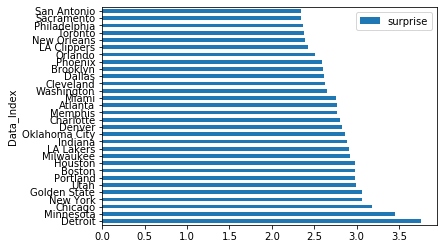

In [59]:
kernelEstimation.plot(kind = "barh", x="Data_Index", y = "surprise")

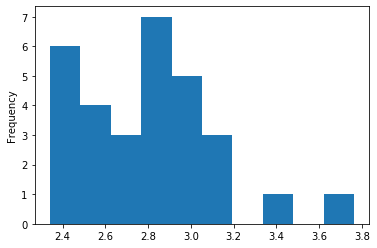

In [60]:
kernelEstimation.get("surprise").plot(kind = "hist")

# Same functionality for Cross - Category

In [65]:
print("Would you like to repeat this process for more categories?")
if(input().upper() == "YES"):
    print("Great! Below are your results:")
# To be Continued...

Would you like to repeat this process for more categories?
yes
Great! Below are your results:
